In [12]:
import torch
import xarray as xr
import mlpost_morocco as mlpost
import pandas as pd


In [13]:
import torch
torch.cuda.is_available()


True

In [14]:
moroccan_locations = {
    "s_sahara": {"Lat": 26.125, "Lon": -13.125},
    "s_sahara_coast": {"Lat": 26.375, "Lon": -12.625},
    "laayoune_area": {"Lat": 26.625, "Lon": -12.375},
    "w_sahara_interior": {"Lat": 26.875, "Lon": -12.125},
    "s_morocco_border": {"Lat": 27.125, "Lon": -11.875},
    "dakhla": {"Lat": 23.875, "Lon": -15.625},
    "dakhla_coast": {"Lat": 24.125, "Lon": -15.375},
    "tarfaya": {"Lat": 27.875, "Lon": -11.375},
    "tan_tan_coast": {"Lat": 28.125, "Lon": -11.125},
    "s_interior": {"Lat": 29.125, "Lon": -9.875},
    "tiznit": {"Lat": 29.375, "Lon": -9.625},
    "agadir_coast": {"Lat": 30.125, "Lon": -9.125},
    "essaouira": {"Lat": 31.125, "Lon": -8.125},
    "el_jadida": {"Lat": 32.125, "Lon": -7.125},
    "casablanca": {"Lat": 33.125, "Lon": -6.125},
    "rabat": {"Lat": 34.125, "Lon": -5.125},
    "tangier": {"Lat": 35.125, "Lon": -4.125},
    "n_coast": {"Lat": 36.125, "Lon": -3.125},
    "n_tip": {"Lat": 37.125, "Lon": -2.125}
}


In [15]:
class precip_postprocessing:

    def __init__(self, model, scaler = None):
        self.model = model
        if scaler:
            self.scaler = scaler

    def load_data(self, observed_fp, predicted_fp, verbose = False): #Loading from the file path
        self.observed_data = xr.open_dataset(observed_fp)
        self.predicted_data = xr.open_dataset(predicted_fp)
        if verbose:
            print(f'CHIRPS NetCDF File: \n{self.observed_data}')
            print(f'NWP NetCDF File: \n{self.predicted_data}')
        print('DATA LOADED SUCCESSFULLY')

    def load_model(self, model):
        self.model = model

    def load_scaler(self, scaler):
        self.scaler = scaler

    def preprocess(self, lead_no): #Must require load_data first
        self.observed = self.observed_data.to_dataframe().reset_index()
        self.predicted = self.predicted_data.to_dataframe().reset_index()
        self.predicted = (
            self.predicted
            .groupby(['Time', 'Lead', 'Lat', 'Lon'])['TP'] #Finding average TP value for all ensembles
            .mean()
            .reset_index()
            .where(self.predicted['Lead']==3)
            .dropna()
            .drop(columns=['Lead'])
            .rename(columns={"TP": "Predicted_TP"})
        )

        self.merged = (
            pd.merge(self.observed, self.predicted, on=['Time', 'Lat', 'Lon'], how = 'left') # <---- THIS IS SPECIFIC TO THIS USE CASE ---- not universal bc of feature names
            .dropna()
         )
        
    def split_by_locations(self, feature_array, target_var):
        self._train = self.merged[self.merged['Location'] == 'none']
        self.X_train = self._train[feature_array].to_numpy()
        self.y_train = self._train[target_var].to_numpy()

        self._test = self.merged[self.merged['Location'] != 'none']

        self.X_test = self._test[feature_array].to_numpy()
        self.y_test = self._test[target_var].to_numpy()

    def add_month_column(self): #Must require preprocess done first.. find 
        self.merged['Month'] = self.merged['Time']%100

    def merge_location_dict(self, d):
        self.location_dict = pd.DataFrame(d).T.reset_index()
        self.merged = (
            self.merged
            .merge(self.location_dict, on=['Lat', 'Lon'], how='left')
            .rename(columns={'index':'Location'})
            .fillna('none')
        )

    def train(self):
        print("BEGINNING TRAINING")
        self.model.fit(self.X_train, self.y_train)
    
    def evaluate(self):
        self.eval_preds = self.model.predict(self.X_test)
        print(f'RMSE: {rmse(self.y_test, self.eval_preds)}')
        print(f'MAE: {mae(self.y_test, self.eval_preds)}')

    def plot_region(self, region):
        self._test['ML_Preds'] = self.eval_preds
        df = self._test[self._test['Location'] == region]
        df.loc[:, ['TP', 'Predicted_TP', 'ML_Preds']].plot()

    def confidence_interval_rf(self, n):
        y_pred_all = []

        for i in range(n):
            print(f"TRAINING RF {i}")

            indices = np.random.choice(np.arange(self.X_train.shape[0]), size=self.X_train.shape[0], replace=True)
            X_boot = self.X_train[indices]
            y_boot = self.y_train[indices]

            rf = RandomForestRegressor()
            rf.fit(X_boot, y_boot)

            y_pred = rf.predict(self.X_test)
            y_pred_all.append(y_pred)

        # Calculate confidence intervals
        self.y_pred_all = np.array(y_pred_all).mean(axis=0)
        self.y_lower = np.percentile(y_pred_all, 2.5, axis=0)
        self.y_upper = np.percentile(y_pred_all, 97.5, axis=0)

        self._test['boot_rf'] = self.y_pred_all
        self._test['upper_ci'] = self.y_upper
        self._test['lower_ci'] = self.y_lower

    def plot_ci(self, region):
        df = self._test[self._test['Location'] == region]
        df.loc[:, ['TP', 'boot_rf', 'upper_ci', 'lower_ci']].plot()

    def run(self):
        self.load_data(
            '../data/raw/CHIRPS_1991_2021_MOR.nc',
            '../data/raw/RAW_CFSv2_1991_2020_MOR.nc',
            verbose=False
        )
        self.preprocess(3)
        self.add_month_column()
        self.merge_location_dict(moroccan_locations)
        self.split_by_locations(['Lat', 'Lon', 'Month', 'Predicted_TP'], 'TP')
        self.train()
        self.evaluate()

In [16]:
post_processor = precip_postprocessing(None)


In [17]:
post_processor.load_data(
    '../data/chirps_data.nc',
    '../data/raw_precip_preds.nc',
    verbose=False
)
post_processor.preprocess(3)
post_processor.add_month_column()
# post_processor.merge_location_dict(moroccan_locations)
# post_processor.split_by_locations(['Lat', 'Lon', 'Month', 'Predicted_TP'], 'TP')


DATA LOADED SUCCESSFULLY


In [18]:
unique_times = post_processor.merged['Time'].unique()
unique_times.sort()

In [30]:
post_processor.merged

,Time,Lat,Lon,TP,Predicted_TP,Month
0,199101,18.875,-19.875,0.0,0.032430,1
1,199101,18.875,-19.625,0.0,0.033503,1
2,199101,18.875,-19.375,0.0,0.034946,1
3,199101,18.875,-19.125,0.0,0.036389,1
4,199101,18.875,-18.875,0.0,0.037832,1
...,...,...,...,...,...,...
193135,199306,37.125,0.625,0.0,2.103576,6
193136,199306,37.125,0.875,0.0,2.239305,6
193137,199306,37.125,1.125,0.0,2.419549,6
193138,199306,37.125,1.375,0.0,2.614631,6


In [19]:
post_processor.merged.head()

,Time,Lat,Lon,TP,Predicted_TP,Month
0,199101,18.875,-19.875,0.0,0.032430,1
1,199101,18.875,-19.625,0.0,0.033503,1
2,199101,18.875,-19.375,0.0,0.034946,1
3,199101,18.875,-19.125,0.0,0.036389,1
4,199101,18.875,-18.875,0.0,0.037832,1


In [20]:
time_slices = []
feature_columns = ['Lat', 'Lon', 'TP', 'Predicted_TP', 'Month']

for time_val in unique_times:
    # Select data for this specific time
    time_data = post_processor.merged[post_processor.merged['Time'] == time_val][feature_columns].values
    time_slices.append(time_data)


In [21]:
time_slices

[array([[ 1.88750000e+01, -1.98750000e+01,  0.00000000e+00,
          3.24304774e-02,  1.00000000e+00],
        [ 1.88750000e+01, -1.96250000e+01,  0.00000000e+00,
          3.35032381e-02,  1.00000000e+00],
        [ 1.88750000e+01, -1.93750000e+01,  0.00000000e+00,
          3.49462479e-02,  1.00000000e+00],
        ...,
        [ 3.71250000e+01,  1.12500000e+00,  0.00000000e+00,
          2.43255496e+00,  1.00000000e+00],
        [ 3.71250000e+01,  1.37500000e+00,  0.00000000e+00,
          2.68780828e+00,  1.00000000e+00],
        [ 3.71250000e+01,  1.62500000e+00,  0.00000000e+00,
          2.94306159e+00,  1.00000000e+00]], shape=(6438, 5)),
 array([[ 1.88750000e+01, -1.98750000e+01,  0.00000000e+00,
          2.47703269e-02,  2.00000000e+00],
        [ 1.88750000e+01, -1.96250000e+01,  0.00000000e+00,
          2.33880971e-02,  2.00000000e+00],
        [ 1.88750000e+01, -1.93750000e+01,  0.00000000e+00,
          2.27111187e-02,  2.00000000e+00],
        ...,
        [ 3.7125000

In [22]:
def reshape_for_conv2d(tensor):
    tensor = tensor.permute(0, 2, 1)  
    
    tensor = tensor.unsqueeze(2)
    
    return tensor

def process_large_tensor(network, tensor):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    network = network.to(device)

    tensor = reshape_for_conv2d(tensor)
    
    torch.cuda.empty_cache()
    
    outputs = []
    for i in range(tensor.size(0)):
        batch = tensor[i:i+1].to(device)
        
        with torch.no_grad():
            output = network(batch)
        
        outputs.append(output.cpu())
    
    return torch.cat(outputs, dim=0)



In [23]:
import Network
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.cuda.empty_cache()

network = Network.Generator(in_channels=5)

reshaped_tensor = torch.tensor(time_slices, dtype=torch.float32)

# reshaped_tensor = reshaped_tensor.permute(0, 2, 1)

# reshaped_tensor = reshaped_tensor.unsqueeze(2)

# print(reshaped_tensor.shape)

# result = network(reshaped_tensor)

output = process_large_tensor(network, reshaped_tensor)

C:\Users\awilder1\AppData\Local\Temp\1\ipykernel_13204\1757504757.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  reshaped_tensor = torch.tensor(time_slices, dtype=torch.float32)


In [24]:
output

tensor([[[[-1.5412e-05, -1.8843e-02, -5.4976e-02,  ...,  1.8591e-01,
            1.0865e-01,  1.4728e-02],
          [ 1.9736e-02,  1.0108e-02, -2.0992e-02,  ...,  2.7824e-01,
            1.9633e-01,  8.3835e-02],
          [-2.9633e-02, -4.4540e-02, -5.2992e-02,  ...,  3.2341e-01,
            2.5070e-01,  1.2601e-01],
          ...,
          [ 2.4077e-02, -3.3781e-02, -3.4921e-02,  ...,  1.2250e-01,
            2.0432e-01,  1.9171e-01],
          [-9.7210e-03, -5.1303e-02, -9.7247e-02,  ...,  1.4707e-01,
            2.5241e-01,  2.8377e-01],
          [-2.4982e-02, -6.5164e-02, -9.6658e-02,  ..., -3.5651e-02,
            5.3142e-02,  5.2483e-02]]],


        [[[-1.5570e-04, -1.5102e-02, -4.8526e-02,  ...,  1.7383e-01,
            9.8764e-02,  6.5146e-03],
          [ 1.2803e-02,  7.6981e-03, -1.0862e-02,  ...,  2.6890e-01,
            1.8799e-01,  8.0081e-02],
          [-4.1870e-02, -4.6886e-02, -3.4681e-02,  ...,  3.1399e-01,
            2.4634e-01,  1.2792e-01],
          ...,
   

In [29]:
output.shape

torch.Size([30, 1, 12, 77256])

In [28]:
len(unique_times)

30

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

def visualize_raw_data(data, feature_names, title_prefix=''):
    """
    Visualize raw geospatial data using subplots
    
    Parameters:
    -----------
    data : numpy.ndarray
        Input data array [time_points, data_points, features]
    feature_names : list
        Names of features to plot
    title_prefix : str, optional
        Prefix for plot titles
    """
    n_features = data.shape[2]
    fig, axes = plt.subplots(1, n_features, figsize=(20, 5))
    
    for i in range(n_features):
        sns.heatmap(data[:, :, i], 
                    cmap='viridis', 
                    ax=axes[i] if n_features > 1 else axes,
                    cbar_kws={'label': feature_names[i]})
        axes[i].set_title(f'{title_prefix}{feature_names[i]}')
    
    plt.tight_layout()
    plt.show()

def visualize_processed_data(tensor, title='Processed Data'):
    """
    Visualize processed tensor from neural network
    
    Parameters:
    -----------
    tensor : torch.Tensor
        Processed tensor from neural network
    title : str, optional
        Title for the visualization
    """
    # Convert tensor to numpy if it's a torch tensor
    if hasattr(tensor, 'detach'):
        tensor = tensor.detach().cpu().numpy()
    
    # Handle different tensor shapes
    if len(tensor.shape) == 4:
        # Assume shape is [batches, channels, height, width]
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(20, 5))
        
        for i in range(tensor.shape[0]):
            sns.heatmap(tensor[i, 0, :, :], 
                        cmap='viridis', 
                        ax=axes[i] if tensor.shape[0] > 1 else axes,
                        cbar_kws={'label': f'Channel {i}'})
            axes[i].set_title(f'{title} - Batch {i}')
    else:
        plt.figure(figsize=(10, 6))
        sns.heatmap(tensor, cmap='viridis')
        plt.title(title)
    
    plt.tight_layout()
    plt.show()

def create_geographical_heatmap(data, lon, lat, feature_name=''):
    plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Add geographical features
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.COASTLINE)
    
    # Plot the heatmap
    mesh = ax.pcolormesh(lon, lat, data, 
                         transform=ccrs.PlateCarree(), 
                         cmap='viridis')
    plt.colorbar(mesh, ax=ax, label=feature_name)
    
    ax.set_title(f'Geographical Heatmap - {feature_name}')
    plt.show()

# Example usage:
# 1. Raw data visualization
feature_names = ['Temperature', 'Precipitation', 'Humidity', 'Wind Speed', 'Pressure']
visualize_raw_data(raw_data, feature_names)

# 2. Processed data visualization
visualize_processed_data(output)

# 3. Geographical heatmap
create_geographical_heatmap(data, longitudes, latitudes, 'Precipitation')

NameError: name 'raw_data' is not defined

In [ ]:
example = output.reshape(30, 12, 77256)

In [ ]:
pd.DataFrame(example)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.015130,-0.020990,-0.075638,-0.057617,-0.088495,-0.124094,-0.088937,-0.083051,-0.062828,-0.077618,-0.094856,-0.029944
1,-0.011295,-0.036432,-0.083326,-0.094418,-0.115663,-0.174587,-0.143328,-0.135230,-0.100391,-0.103341,-0.112640,-0.052589
2,-0.031893,-0.037775,-0.046187,-0.101614,-0.177181,-0.208426,-0.205416,-0.203518,-0.160650,-0.150220,-0.112418,-0.042728
3,-0.022953,-0.033903,0.000258,-0.051686,-0.128632,-0.159235,-0.164266,-0.084109,-0.084031,-0.067338,-0.052529,0.025313
4,0.032088,0.021861,0.061061,0.001528,-0.044602,-0.064507,-0.098301,-0.020498,0.010597,0.003163,-0.056137,0.008995
...,...,...,...,...,...,...,...,...,...,...,...,...
77251,0.295680,0.349016,0.450547,0.578432,0.364320,0.402211,0.367691,0.337022,0.241822,0.084347,-0.060283,0.001427
77252,0.348255,0.375025,0.379745,0.419281,0.283089,0.301242,0.266107,0.282801,0.240679,0.053114,-0.038359,-0.004023
77253,0.271533,0.343927,0.355397,0.360786,0.244270,0.232025,0.236385,0.158773,0.175661,0.005488,-0.088958,-0.011764
77254,0.223715,0.272467,0.300604,0.274366,0.198613,0.188448,0.080648,0.047232,0.009775,-0.022971,-0.141383,-0.100084


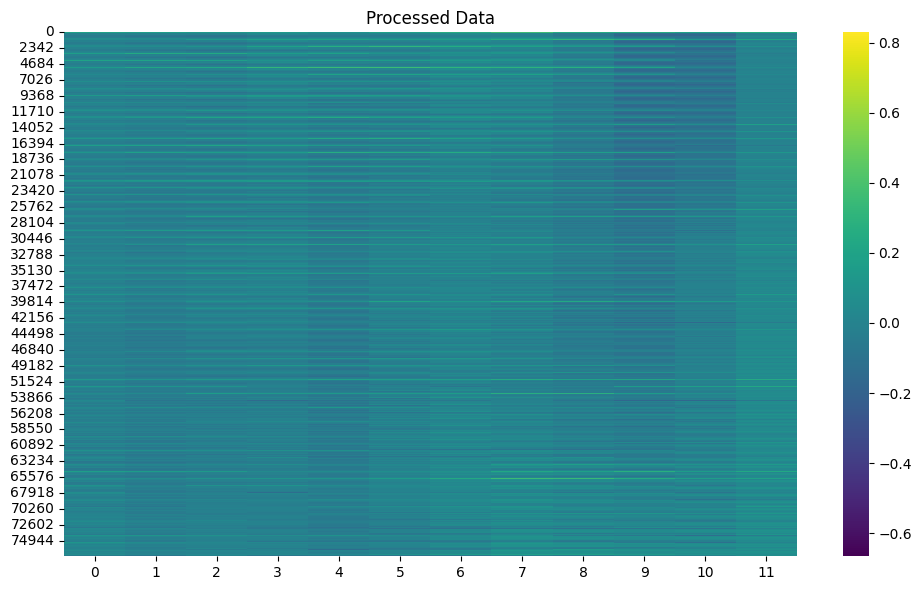

In [ ]:
visualize_processed_data(example)